### Forecasting DC COVID-19 Deaths

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC  
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
import datetime as dt

In [2]:
covid = pd.read_csv("covid-states.csv")
covid.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2020-12-02,AK,A,122.0,122.0,0,NaN,768.0,768.0,164.0,...,1024643.0,6015,NaN,NaN,NaN,NaN,NaN,0,1024643.0,6015
1,2020-12-02,AL,A,3711.0,3326.0,73,385.0,25821.0,25821.0,1801.0,...,1603523.0,9681,NaN,NaN,73187.0,NaN,1603523.0,9681,NaN,0
2,2020-12-02,AR,A+,2522.0,2312.0,10,210.0,9110.0,9110.0,1088.0,...,1703266.0,11813,NaN,21856.0,NaN,144866.0,NaN,0,1703266.0,11813
3,2020-12-02,AS,D,0.0,NaN,0,NaN,NaN,NaN,NaN,...,1988.0,0,NaN,NaN,NaN,NaN,NaN,0,1988.0,0
4,2020-12-02,AZ,A+,6739.0,6237.0,52,502.0,26312.0,26312.0,2699.0,...,2288204.0,16290,365871.0,NaN,NaN,NaN,2288204.0,16290,NaN,0


In [3]:
#print("Size/Shape of the dataset",covid.shape)
#print("Checking for null values:\n",covid.isnull().sum())
#print("Checking Data-type:",covid.dtypes)

In [4]:
covid.columns

Index(['date', 'state', 'dataQualityGrade', 'death', 'deathConfirmed',
       'deathIncrease', 'deathProbable', 'hospitalized',
       'hospitalizedCumulative', 'hospitalizedCurrently',
       'hospitalizedIncrease', 'inIcuCumulative', 'inIcuCurrently', 'negative',
       'negativeIncrease', 'negativeTestsAntibody',
       'negativeTestsPeopleAntibody', 'negativeTestsViral',
       'onVentilatorCumulative', 'onVentilatorCurrently', 'positive',
       'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral'

In [5]:
#Drop columns
covid.drop(['dataQualityGrade','deathIncrease',\
       'deathProbable','hospitalizedCumulative','hospitalizedIncrease',\
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',\
       'negativeTestsViral', 'onVentilatorCumulative','positiveScore',\
       'positiveTestsAntibody', 'positiveTestsAntigen',\
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',\
       'totalTestEncountersViralIncrease', 'totalTestResults',\
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',\
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen','deathConfirmed','hospitalized','inIcuCumulative',\
       'positiveCasesViral', 'positiveTestsViral',\
       'totalTestsViral','totalTestsViralIncrease'],1,inplace = True)

In [6]:
covid.columns

Index(['date', 'state', 'death', 'hospitalizedCurrently', 'inIcuCurrently',
       'negative', 'negativeIncrease', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease'],
      dtype='object')

In [7]:
covid = covid.fillna(0)
covid.head()

,date,state,death,hospitalizedCurrently,inIcuCurrently,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestEncountersViral,totalTestsPeopleViral,totalTestsPeopleViralIncrease
0,2020-12-02,AK,122.0,164.0,0.0,992112.0,5318,23.0,32531.0,697,7165.0,0.0,0.0,0
1,2020-12-02,AL,3711.0,1801.0,0.0,1390351.0,6546,0.0,256828.0,3928,168387.0,0.0,1603523.0,9681
2,2020-12-02,AR,2522.0,1088.0,393.0,1562561.0,10306,186.0,161521.0,2212,142600.0,0.0,0.0,0
3,2020-12-02,AS,0.0,0.0,0.0,1988.0,0,0.0,0.0,0,0.0,0.0,0.0,0
4,2020-12-02,AZ,6739.0,2699.0,642.0,1957887.0,12811,386.0,340979.0,3840,53694.0,0.0,2288204.0,16290


### Remove empty date from data - First death logged 2020-03-20

In [8]:
start_date = "2020-03-20"
end_date = "2020-12-02"
mask = (covid["date"] > start_date) & (covid["date"] <= end_date)
cut_date_df = covid.loc[mask]
cut_date_df

,date,state,death,hospitalizedCurrently,inIcuCurrently,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestEncountersViral,totalTestsPeopleViral,totalTestsPeopleViralIncrease
0,2020-12-02,AK,122.0,164.0,0.0,992112.0,5318,23.0,32531.0,697,7165.0,0.0,0.0,0
1,2020-12-02,AL,3711.0,1801.0,0.0,1390351.0,6546,0.0,256828.0,3928,168387.0,0.0,1603523.0,9681
2,2020-12-02,AR,2522.0,1088.0,393.0,1562561.0,10306,186.0,161521.0,2212,142600.0,0.0,0.0,0
3,2020-12-02,AS,0.0,0.0,0.0,1988.0,0,0.0,0.0,0,0.0,0.0,0.0,0
4,2020-12-02,AZ,6739.0,2699.0,642.0,1957887.0,12811,386.0,340979.0,3840,53694.0,0.0,2288204.0,16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14387,2020-03-21,VT,2.0,0.0,0.0,1080.0,123,0.0,52.0,8,0.0,0.0,1141.0,153
14388,2020-03-21,WA,111.0,0.0,0.0,42741.0,2236,0.0,2965.0,194,0.0,45706.0,44847.0,2342
14389,2020-03-21,WI,4.0,0.0,0.0,4628.0,1173,0.0,315.0,80,0.0,6050.0,0.0,0
14390,2020-03-21,WV,0.0,0.0,0.0,330.0,111,0.0,11.0,4,0.0,0.0,0.0,0


In [9]:
# Export the US data csv - when you review the exported file there are 0 deaths reported for DC!
cut_date_df.to_csv("us_covid.csv")

In [10]:
#Data Analysis for Washington DC
dc_data = cut_date_df[cut_date_df["state"]=="DC"]
dc_data.head()

,date,state,death,hospitalizedCurrently,inIcuCurrently,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestEncountersViral,totalTestsPeopleViral,totalTestsPeopleViralIncrease
8,2020-12-02,DC,690.0,165.0,41.0,679643.0,3919,18.0,21842.0,157,16070.0,701485.0,308164.0,828
64,2020-12-01,DC,685.0,160.0,43.0,675724.0,2020,18.0,21685.0,133,15914.0,697409.0,307336.0,889
120,2020-11-30,DC,680.0,158.0,43.0,673704.0,4810,17.0,21552.0,104,15746.0,695256.0,306447.0,884
176,2020-11-29,DC,680.0,145.0,42.0,668894.0,4864,21.0,21448.0,140,15671.0,690342.0,305563.0,1530
232,2020-11-28,DC,678.0,157.0,41.0,664030.0,12528,16.0,21308.0,371,15603.0,685338.0,304033.0,4071


In [11]:
dc_data.columns

Index(['date', 'state', 'death', 'hospitalizedCurrently', 'inIcuCurrently',
       'negative', 'negativeIncrease', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease'],
      dtype='object')

In [12]:
# Export the DC data csv 
dc_data.to_csv("dc_covid.csv")

In [13]:
dc_data.dtypes


date                              object
state                             object
death                            float64
hospitalizedCurrently            float64
inIcuCurrently                   float64
negative                         float64
negativeIncrease                   int64
onVentilatorCurrently            float64
positive                         float64
positiveIncrease                   int64
recovered                        float64
totalTestEncountersViral         float64
totalTestsPeopleViral            float64
totalTestsPeopleViralIncrease      int64
dtype: object

In [14]:
# convert date object to datetime
con=dc_data['date']
dc_data['date']=pd.to_datetime(dc_data['date'])
dc_data.set_index('date', inplace=True)
#check datatype of index
dc_data.index

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


DatetimeIndex(['2020-12-02', '2020-12-01', '2020-11-30', '2020-11-29',
               '2020-11-28', '2020-11-27', '2020-11-26', '2020-11-25',
               '2020-11-24', '2020-11-23',
               ...
               '2020-03-30', '2020-03-29', '2020-03-28', '2020-03-27',
               '2020-03-26', '2020-03-25', '2020-03-24', '2020-03-23',
               '2020-03-22', '2020-03-21'],
              dtype='datetime64[ns]', name='date', length=257, freq=None)

In [15]:
dc_data.columns

Index(['state', 'death', 'hospitalizedCurrently', 'inIcuCurrently', 'negative',
       'negativeIncrease', 'onVentilatorCurrently', 'positive',
       'positiveIncrease', 'recovered', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease'],
      dtype='object')

In [16]:
#convert to time series:
ts_dc = dc_data
ts_dc.head(10)

,state,death,hospitalizedCurrently,inIcuCurrently,negative,negativeIncrease,onVentilatorCurrently,positive,positiveIncrease,recovered,totalTestEncountersViral,totalTestsPeopleViral,totalTestsPeopleViralIncrease
date,,,,,,,,,,,,,
2020-12-02,DC,690.0,165.0,41.0,679643.0,3919,18.0,21842.0,157,16070.0,701485.0,308164.0,828
2020-12-01,DC,685.0,160.0,43.0,675724.0,2020,18.0,21685.0,133,15914.0,697409.0,307336.0,889
2020-11-30,DC,680.0,158.0,43.0,673704.0,4810,17.0,21552.0,104,15746.0,695256.0,306447.0,884
2020-11-29,DC,680.0,145.0,42.0,668894.0,4864,21.0,21448.0,140,15671.0,690342.0,305563.0,1530
2020-11-28,DC,678.0,157.0,41.0,664030.0,12528,16.0,21308.0,371,15603.0,685338.0,304033.0,4071
2020-11-27,DC,677.0,149.0,34.0,651502.0,9037,18.0,20937.0,201,15476.0,672439.0,299962.0,2529
2020-11-26,DC,677.0,146.0,30.0,642465.0,12746,14.0,20736.0,220,15401.0,663201.0,297433.0,3136
2020-11-25,DC,677.0,134.0,36.0,629719.0,1206,19.0,20516.0,107,15281.0,650235.0,294297.0,1465
2020-11-24,DC,673.0,134.0,36.0,628513.0,9342,13.0,20409.0,119,15085.0,648922.0,292832.0,1804


In [17]:
ts = dc_data['death']
ts.head()

date
2020-12-02    690.0
2020-12-01    685.0
2020-11-30    680.0
2020-11-29    680.0
2020-11-28    678.0
Name: death, dtype: float64

In [18]:
#indexing techniques for TS data. 
#Lets start by selecting a particular value in the Series object.
ts['2020-11-23']

date
2020-11-23    672.0
Name: death, dtype: float64

In [19]:
#Specify the entire range:
ts['2020-01-22':]

Series([], Name: death, dtype: float64)

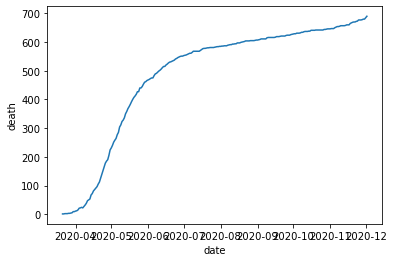

In [20]:
plt.ylabel('death')
plt.xlabel('date')
plt.plot(ts)

##### It is clearly evident that there is an overall increasing trend in the data 

## Check Stationarity Time Series Data

#### TS is said to be stationary if its statistical properties such as mean, variance remain constant over time
- constant mean
- constant variance
- an autocovariance that does not depend on time.

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

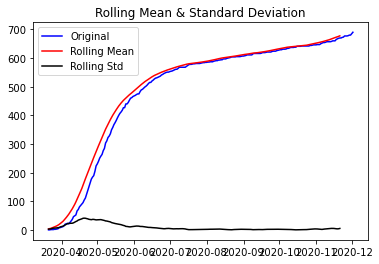

Results of Dickey-Fuller Test:
Test Statistic                  -2.199744
p-value                          0.206338
#Lags Used                      11.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [23]:
test_stationarity(ts)

### The TS is stationary? the test statistic is smaller than 1% of the critical value.

### This TS is not stationary:
- mean is increasing even though the std is small.
- Test stat is > critical value.

### How to make the Time Series Stationary
-The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

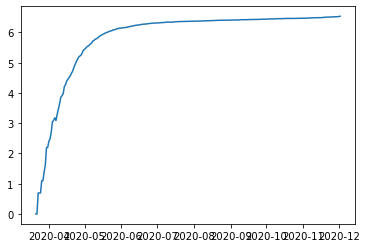

In [24]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Moving Average

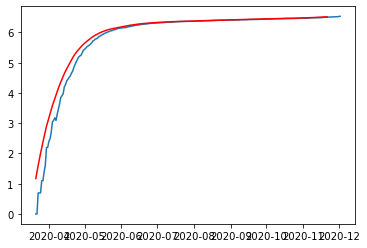

In [25]:
moving_avg = pd.Series.rolling(ts_log,12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [26]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

date
2020-12-02         NaN
2020-12-01         NaN
2020-11-30         NaN
2020-11-29         NaN
2020-11-28         NaN
2020-11-27         NaN
2020-11-26         NaN
2020-11-25         NaN
2020-11-24         NaN
2020-11-23         NaN
2020-11-22         NaN
2020-11-21   -0.010974
Name: death, dtype: float64

#### The reason there are null values is because we take the average of first 12 so 11 values are null. We can also see that in the visual representation. Thus it is dropped for further analysis. Now let’s parse it to the function to check for stationarity.

In [27]:
ts_log_moving_avg_diff.dropna(inplace=True)

In [28]:
ts_log_moving_avg_diff.isnull().sum()

0

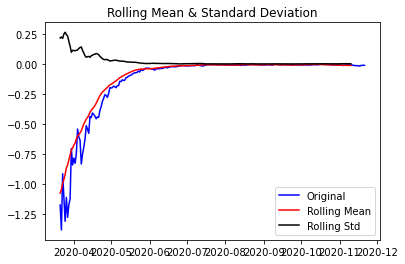

Results of Dickey-Fuller Test:
Test Statistic                   3.205736
p-value                          1.000000
#Lags Used                      16.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


In [29]:
test_stationarity(ts_log_moving_avg_diff)

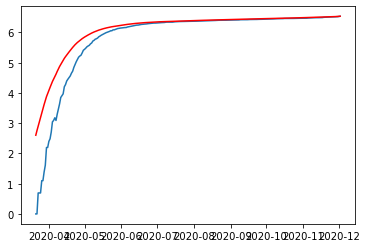

In [30]:
#the parameter ‘halflife’ is used to define the amount of exponential decay
#halflife? Is this the number of month/years data?
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

In [31]:
ts_log_ewma_diff = ts_log - expwighted_avg

In [32]:
ts_log_ewma_diff

date
2020-12-02    0.000000
2020-12-01   -0.003531
2020-11-30   -0.007027
2020-11-29   -0.005115
2020-11-28   -0.006257
                ...   
2020-03-25   -2.501066
2020-03-24   -2.360692
2020-03-23   -2.228196
2020-03-22   -2.757381
2020-03-21   -2.602621
Name: death, Length: 257, dtype: float64

In [33]:
#ts_log_ewma_diff.replace([np.inf, -np.inf], np.nan)

In [34]:
#ts_log_ewma_diff.fillna(0)

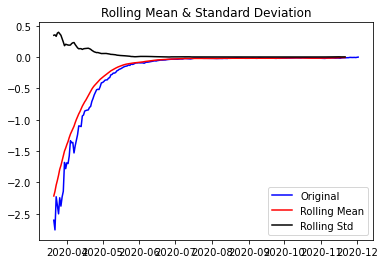

Results of Dickey-Fuller Test:
Test Statistic                   2.124553
p-value                          0.998814
#Lags Used                      16.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [35]:
test_stationarity(ts_log_ewma_diff)

### Differencing
-One of the most common methods of dealing with both trend and seasonality is differencing

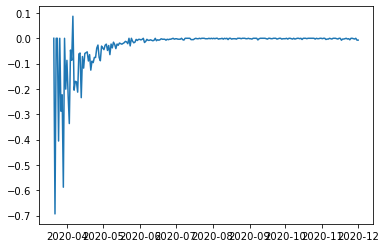

In [36]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

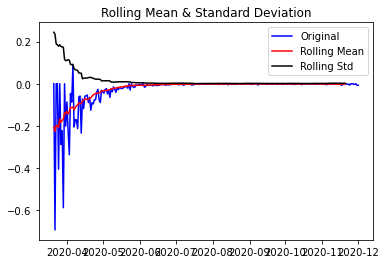

Results of Dickey-Fuller Test:
Test Statistic                   7.689688
p-value                          1.000000
#Lags Used                      16.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


In [37]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

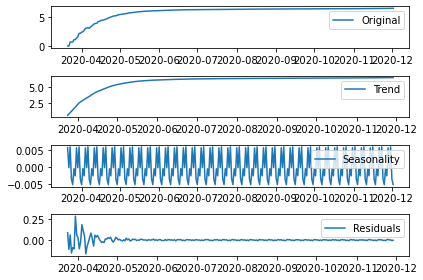

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Here we can see that the trend, seasonality are separated out from data and we can model the residuals.

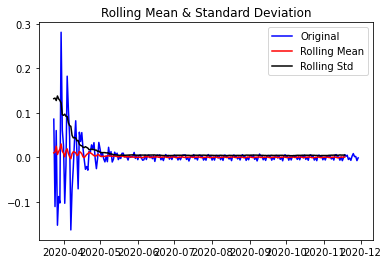

Results of Dickey-Fuller Test:
Test Statistic                   1.237139
p-value                          0.996233
#Lags Used                      16.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [39]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Forecasting Time Series

In [40]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [41]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Autocorrelation Function')

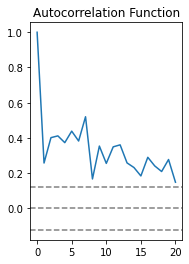

In [42]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

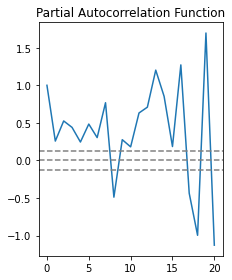

In [43]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [44]:
from statsmodels.tsa.arima_model import ARIMA

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency infor

Text(0.5, 1.0, 'RSS: 1.1531')

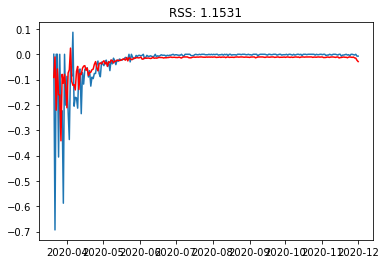

In [45]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  % freq, ValueWarning)
/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.2782')

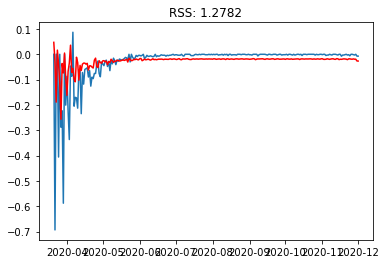

In [46]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [47]:
predictions_ARIMA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2020-12-01   -0.026718
2020-11-30   -0.026383
2020-11-29   -0.019328
2020-11-28   -0.019381
2020-11-27   -0.018229
dtype: float64


In [48]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2020-12-01   -0.026718
2020-11-30   -0.053101
2020-11-29   -0.072429
2020-11-28   -0.091810
2020-11-27   -0.110039
dtype: float64
